# Use OSMnx to calculate street network indicators

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd

%matplotlib inline
ox.__version__

'1.5.1'

## Calculate basic street network measures (topological and geometric)

## 기본 거리 네트워크 측정값 계산(위상 및 기하학적)

In [2]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
# Piedmont에 대한 네트워크를 가져오고 기본 통계를 계산한 다음 평균 회로를 표시합니다.

stats = ox.basic_stats(ox.graph_from_place("Piedmont, California, USA"))
stats["circuity_avg"]

1.0747652784552435

To calculate density-based stats, you must also pass the network's bounding area in square meters (otherwise basic_stats() will just skip them in the calculation):

밀도 기반 통계를 계산하려면 평방 미터 단위의 네트워크 경계 영역도 전달해야 합니다(그렇지 않으면 basic_stats()가 계산에서 건너뜁니다).

In [3]:
# get the street network for a place, and its area in square meters
place = "Piedmont, California, USA"
gdf = ox.geocode_to_gdf(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type="drive")

In [4]:
# calculate basic and extended network stats, merge them together, and display 기본 및 확장 네트워크 통계를 계산하고 함께 병합하고 표시합니다.
stats = ox.basic_stats(G, area=area)
pd.Series(stats)

n                                                                             353
m                                                                             948
k_avg                                                                    5.371105
edge_length_total                                                      112041.089
edge_length_avg                                                        118.186803
streets_per_node_avg                                                     2.951841
streets_per_node_counts                  {0: 0, 1: 34, 2: 0, 3: 270, 4: 47, 5: 2}
streets_per_node_proportions    {0: 0.0, 1: 0.09631728045325778, 2: 0.0, 3: 0....
intersection_count                                                            319
street_length_total                                                     58084.309
street_segment_count                                                          497
street_length_avg                                                      116.869837
circuity_avg    

Streets/intersection counts and proportions are nested dicts inside the stats dict. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

거리/교차로 개수 및 비율은 stats dict 내부의 중첩된 dict입니다. 이러한 통계를 pandas 데이터 프레임으로 변환하려면(여러 네트워크를 서로 비교/분석하기 위해) 먼저 이러한 중첩된 사전의 압축을 풉니다.

In [5]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats["streets_per_node_counts"].items():
    stats["{}way_int_count".format(k)] = count
for k, proportion in stats["streets_per_node_proportions"].items():
    stats["{}way_int_prop".format(k)] = proportion

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name="value")).round(3)

,value
n,353.000
m,948.000
k_avg,5.371
edge_length_total,112041.089
edge_length_avg,118.187
streets_per_node_avg,2.952
intersection_count,319.000
street_length_total,58084.309
street_segment_count,497.000
street_length_avg,116.870


### Inspect betweenness centrality 매개 중심성(그래프에서 상대적 중요성을 나타내는 척도) 검사

In [6]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(53124805, 0.3165549728049728)

In the city of Piedmont, California, the node with the highest betweenness centrality has ~31% of all shortest paths running through it. Let's highlight it in the plot:

캘리포니아 피에몬테 시에서 매개 중심성이 가장 높은 노드는 전체 최단 경로의 ~31%를 통과합니다. 줄거리에서 강조해 보겠습니다.

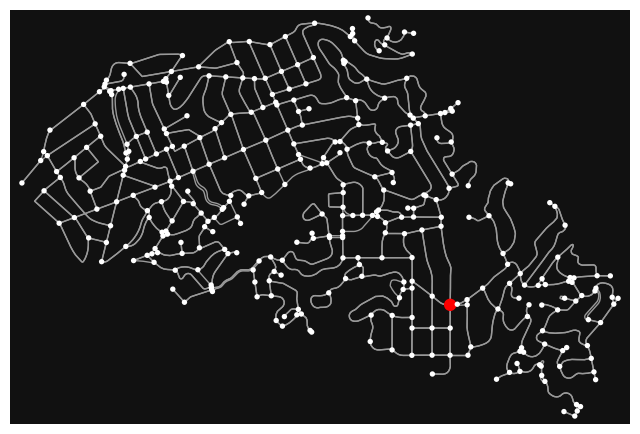

In [7]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

~30% of all shortest paths run through the node highlighted in red. Let's look at the relative betweenness centrality of every node in the graph:

모든 최단 경로의 ~30%는 빨간색으로 강조 표시된 노드를 통과합니다. 그래프에 있는 모든 노드의 상대적 매개 중심성을 살펴보겠습니다.

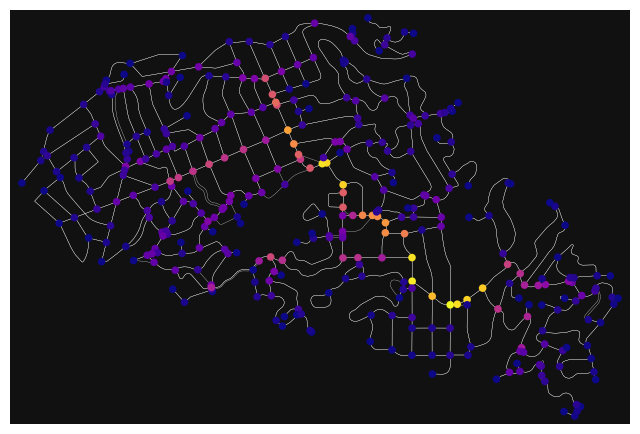

In [8]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.

위의 노드는 낮은(진한 보라색)에서 높은(연한 노란색)까지 중간 중심성으로 시각화됩니다. 색상 공간의 색상은 속성 값에 선형으로 매핑됩니다.